In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Gaussian Symmetry functions
Sollten im wende punkt über lappen, d.h. abstand zweier Gaussians i,j $$d_{ij} = (\sigma_i + \sigma_j)/2 $$
$$\sigma^2 = \frac{1}{\eta}$$

## Radial 

In [2]:
def symmetry_function(x, rs, eta=0.5):
    return np.exp(-eta*(x - rs)**2)

def cut_off(x, r_cutoff):
    
    L = x > r_cutoff
    
    out = 0.5 * (np.cos(np.pi * x / r_cutoff) + 1)
    
    try:
        # works only of out is non scalar
        out[x > r_cutoff] = 0
    except:
        if x > r_cutoff:
            out = 0
        
    return out

In [3]:
n_r = 5
r_cutoff = 4
#Rs = np.arange(1,n + 1) * r_cutoff / (n+1)
Rs = np.array([0,0,0, 0, 0]) #np.array([0.6, 1., 1.2, 1.5, 2.0])
eta_r = np.array([1.2, 0.5, 0.2, 0.1, 0.01])

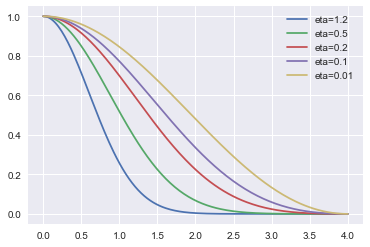

In [4]:


plt.figure()
x = np.linspace(0, r_cutoff, 200)

for e, rs in zip(eta_r, Rs):
    plt.plot(x, symmetry_function(x, rs, e) * cut_off(x, r_cutoff), label="eta="+str(e))

plt.legend()
plt.show()


## Angles: 
Displayed w/o cutoff function

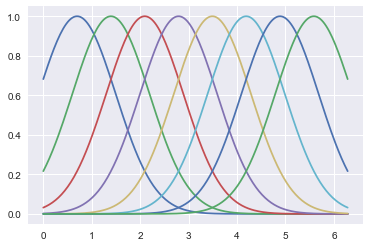

In [5]:
n_phi = 8
phi_s = np.arange(1,n_phi + 1) * 2 * np.pi / (n_phi+1)
eta_phi = 1/(n_phi / (2*np.pi))

plt.figure()
x = np.linspace(0, 2*np.pi, 200)

for rs in phi_s:
    plt.plot(x, symmetry_function(x, rs, eta_phi))
plt.show()

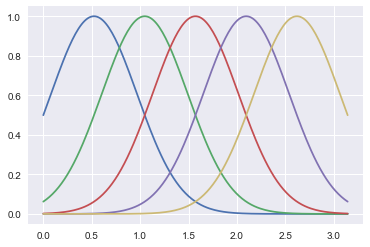

In [6]:
n_theta = 5
theta_s = np.arange(1, n_theta + 1) * np.pi / (n_theta + 1)
eta_theta = (n_theta / (np.pi))**2

plt.figure()
x = np.linspace(0, np.pi, 200)

for rs in theta_s:
    plt.plot(x, symmetry_function(x, rs, eta_theta))
plt.show()

# Apply
- all funcitons weighted by  r cut-off function
- phi and theta just guassians
- phi from [0, 2Pi], theta [0,Pi]

In [7]:
#R_s = np.arange(1,n + 1) * r_cutoff / (n+1)


def spherical_coordinates(x):
    r = np.sqrt(np.sum(x**2))
    phi = np.arctan2(x, x[0])[0]
    theta = np.arccos(x[2] / r)
    
    return r, phi, theta
    

def atomic_descriptors(R):
    """R... direction atom i to atom j"""
    r, phi, theta = spherical_coordinates(R)
    G = []
    
    for r_s in R_s:
        G.append(symmetry_function(r, r_s) * cut_off(r, R_cutoff))

    for phi_s in PHI_s:
        G.append(symmetry_function(phi, phi_s) * cut_off(r, R_cutoff))

    for theta_s in THETA_s:
        G.append(symmetry_function(theta, theta_s) * cut_off(r, R_cutoff))

        
    return G
                                                                                            
def calculate_descriptor(molecule_geometry, number_of_descriptors):
    
    descriptor_molecule = []
    
    for i, geom_i in enumerate(molecule_geometry):
        
        descriptor_atom = np.zeros(number_of_descriptors)
        
        for j, geom_j in enumerate(molecule_geometry):
            if i == j:
                continue
            
            descriptor_atom += np.array(atomic_descriptors(geom_i - geom_j))
            
        descriptor_molecule.append(descriptor_atom)
    return descriptor_molecule

# Actual molecule 

In [8]:
molecules = np.load("../data/400/molecules400.npy")
S = np.load("../data/400/S400.npy")
P = np.load("../data/400/P400.npy")

R_s = Rs
ETA_R = eta_r
PHI_s = phi_s
ETA_PHI = eta_phi
THETA_s = theta_s
ETA_THETA = eta_theta

R_cutoff = 4

dim = 26
dim_in = 10 * (n_r + n_phi + n_theta)
dim_triu = int(26 * 27 / 2)

In [9]:
descriptors = np.array([calculate_descriptor(np.array(mol.positions), n_r + n_phi + n_theta) for mol in molecules])

In [10]:
descriptors = descriptors.reshape(603, -1)

In [11]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

dataset, molecules = make_butadien_dataset(
    molecules,
    descriptors,
    np.array(list(map(lambda x: extract_triu(x, dim), P))),
    test_samples=100
)

[-] 2018-06-21 20:17:57: Data set normalized. Mean value std: 0.21831658728824882


In [12]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

structure = [dim_in,  dim_triu, dim_triu - 100, int(dim_triu/2), dim_triu]

trainer = Trainer(
    EluTrNNN(structure),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer.setup()

network, sess = trainer.train(
    dataset,
    convergence_threshold=5e-7
)

[-] 2018-06-21 20:17:57: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-21 20:17:57: Setting up the training in the target graph ...
[-] 2018-06-21 20:17:57: network ...
[-] 2018-06-21 20:17:57: error function ...
[-] 2018-06-21 20:17:57: cost function ...
[-] 2018-06-21 20:17:59: training step
[-] 2018-06-21 20:17:59: Starting network training ...
[ ] 2018-06-21 20:17:59: Val. Cost: 9.434E-02. Error: 9.434E-02. Diff: 1.0E+10
[ ] 2018-06-21 20:18:01: Val. Cost: 1.966E-04. Error: 1.949E-04. Diff: 9.4E-02
[ ] 2018-06-21 20:18:02: Val. Cost: 1.691E-04. Error: 1.672E-04. Diff: 2.8E-05
[ ] 2018-06-21 20:18:04: Val. Cost: 1.054E-04. Error: 1.033E-04. Diff: 6.4E-05
[ ] 2018-06-21 20:18:05: Val. Cost: 8.863E-05. Error: 8.635E-05. Diff: 1.7E-05
[ ] 2018-06-21 20:18:07: Val. Cost: 5.582E-05. Error: 5.336E-05. Diff: 3.3E-05
[ ] 2018-06-21 20:18:08: Val. Cost: 4.000E-05. Error: 3.735E-05. Diff: 1.6E-05
[ ] 2018-06-21 20:18:09: Val. Cost: 3.193E-05. Error: 2.913E-05

In [13]:
with trainer.graph.as_default():
    p_nn = network.run(sess, dataset.testing[0])

## Analyze

In [14]:
from SCFInitialGuess.utilities.analysis import measure_absolute_error, statistics
statistics(measure_absolute_error(p_nn, dataset))

(0.0012853492716230195, 0.0002606295238283631)

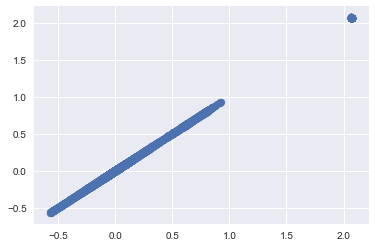

In [15]:
plt.scatter(p_nn.flatten(), dataset.testing[1].flatten())
plt.show()

In [16]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu
np.array(list(map(lambda x: reconstruct_from_triu(x, dim), p_nn))).reshape(-1, dim, dim).shape

(100, 26, 26)

In [17]:
from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

iterations = measure_iterations(
    mf_initializer, 
    np.array(list(map(lambda x: reconstruct_from_triu(x, dim), p_nn))).reshape(-1, dim, dim).astype("float64"), 
    molecules[1]
)

statistics(iterations)

[ ] 2018-06-21 20:19:09: Iteration calculation: 0
[ ] 2018-06-21 20:19:09: Iteration calculation: 1
[ ] 2018-06-21 20:19:10: Iteration calculation: 2
[ ] 2018-06-21 20:19:10: Iteration calculation: 3
[ ] 2018-06-21 20:19:11: Iteration calculation: 4
[ ] 2018-06-21 20:19:11: Iteration calculation: 5
[ ] 2018-06-21 20:19:11: Iteration calculation: 6
[ ] 2018-06-21 20:19:11: Iteration calculation: 7
[ ] 2018-06-21 20:19:12: Iteration calculation: 8
[ ] 2018-06-21 20:19:12: Iteration calculation: 9
[ ] 2018-06-21 20:19:12: Iteration calculation: 10
[ ] 2018-06-21 20:19:12: Iteration calculation: 11
[ ] 2018-06-21 20:19:13: Iteration calculation: 12
[ ] 2018-06-21 20:19:13: Iteration calculation: 13
[ ] 2018-06-21 20:19:14: Iteration calculation: 14
[ ] 2018-06-21 20:19:14: Iteration calculation: 15
[ ] 2018-06-21 20:19:14: Iteration calculation: 16
[ ] 2018-06-21 20:19:15: Iteration calculation: 17
[ ] 2018-06-21 20:19:15: Iteration calculation: 18
[ ] 2018-06-21 20:19:15: Iteration calcul

(10.08, 1.7814600753314678)

#  Electronegativity weighted

In [18]:
from SCFInitialGuess.utilities.constants import electronegativities as CHI

def calculate_descriptor_chi(molecule_geometry,  number_of_descriptors):
    
    descriptor_molecule = []
    
    for i, geom_i in enumerate(molecule_geometry):
        
        descriptor_atom = np.zeros(number_of_descriptors)
        
        for j, geom_j in enumerate(molecule_geometry):
            if i == j:
                continue
            
            descriptor_atom += CHI[geom_j[0]] *  np.array(atomic_descriptors(
                np.array(geom_i[1]) - np.array(geom_j[1])))
            
        descriptor_molecule.append(descriptor_atom)
    return descriptor_molecule

In [19]:
molecules = np.load("../data/400/molecules400.npy")
descriptors_chi = np.array([calculate_descriptor_chi(list(mol.geometry), n_r + n_phi + n_theta) for mol in molecules])

In [20]:
descriptors_chi = descriptors_chi.reshape(603, -1)

In [21]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

molecules = np.load("../data/400/molecules400.npy")

dataset_chi, molecules = make_butadien_dataset(
    molecules,
    descriptors_chi,
    np.array(list(map(lambda x: extract_triu(x, dim), P))),
    test_samples=100
)

[-] 2018-06-21 20:19:48: Data set normalized. Mean value std: 0.5088632594892084


In [30]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

#structure = [dim_in,  dim_triu * 2, dim_triu + 100, dim_triu]
#structure = [dim_in,  dim_triu, dim_triu - 100, int(dim_triu/2), dim_triu]

trainer_chi = Trainer(
    EluTrNNN(structure),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)
1
trainer_chi.setup()

network_chi, sess_chi = trainer_chi.train(
    dataset_chi,
    convergence_threshold=5e-7
)

[-] 2018-06-21 20:47:30: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-21 20:47:30: Setting up the training in the target graph ...
[-] 2018-06-21 20:47:30: network ...
[-] 2018-06-21 20:47:30: error function ...
[-] 2018-06-21 20:47:30: cost function ...
[-] 2018-06-21 20:47:30: training step
[-] 2018-06-21 20:47:30: Starting network training ...
[ ] 2018-06-21 20:47:30: Val. Cost: 9.412E-02. Error: 9.412E-02. Diff: 1.0E+10
[ ] 2018-06-21 20:47:31: Val. Cost: 2.487E-04. Error: 2.469E-04. Diff: 9.4E-02
[ ] 2018-06-21 20:47:32: Val. Cost: 2.327E-04. Error: 2.308E-04. Diff: 1.6E-05
[ ] 2018-06-21 20:47:33: Val. Cost: 1.508E-04. Error: 1.487E-04. Diff: 8.2E-05
[ ] 2018-06-21 20:47:34: Val. Cost: 1.269E-04. Error: 1.246E-04. Diff: 2.4E-05
[ ] 2018-06-21 20:47:35: Val. Cost: 1.015E-04. Error: 9.910E-05. Diff: 2.6E-05
[ ] 2018-06-21 20:47:36: Val. Cost: 7.250E-05. Error: 6.993E-05. Diff: 2.9E-05
[ ] 2018-06-21 20:47:36: Val. Cost: 4.987E-05. Error: 4.713E-05

In [89]:
with trainer.graph.as_default():
    p_nn_chi = network_chi.run(sess_chi, dataset_chi.testing[0])

## Chi analysis

In [88]:
from SCFInitialGuess.utilities.analysis import measure_absolute_error, statistics
print(statistics(measure_absolute_error(p_nn_chi, dataset_chi)))


(0.0018518574267043547, 0.00034713443989896727)


In [33]:

from SCFInitialGuess.utilities.analysis import measure_iterations, mf_initializer
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

iterations = measure_iterations(
    mf_initializer, 
    np.array(list(map(lambda x: reconstruct_from_triu(x, dim), p_nn_chi))).reshape(-1, dim, dim).astype("float64"), 
    molecules[1]
)

statistics(iterations)

[ ] 2018-06-21 20:47:51: Iteration calculation: 0
[ ] 2018-06-21 20:47:52: Iteration calculation: 1
[ ] 2018-06-21 20:47:52: Iteration calculation: 2
[ ] 2018-06-21 20:47:52: Iteration calculation: 3
[ ] 2018-06-21 20:47:52: Iteration calculation: 4
[ ] 2018-06-21 20:47:52: Iteration calculation: 5
[ ] 2018-06-21 20:47:53: Iteration calculation: 6
[ ] 2018-06-21 20:47:53: Iteration calculation: 7
[ ] 2018-06-21 20:47:53: Iteration calculation: 8
[ ] 2018-06-21 20:47:53: Iteration calculation: 9
[ ] 2018-06-21 20:47:54: Iteration calculation: 10
[ ] 2018-06-21 20:47:54: Iteration calculation: 11
[ ] 2018-06-21 20:47:54: Iteration calculation: 12
[ ] 2018-06-21 20:47:54: Iteration calculation: 13
[ ] 2018-06-21 20:47:55: Iteration calculation: 14
[ ] 2018-06-21 20:47:55: Iteration calculation: 15
[ ] 2018-06-21 20:47:55: Iteration calculation: 16
[ ] 2018-06-21 20:47:55: Iteration calculation: 17
[ ] 2018-06-21 20:47:56: Iteration calculation: 18
[ ] 2018-06-21 20:47:56: Iteration calcul

(11.56, 1.1074294559925704)

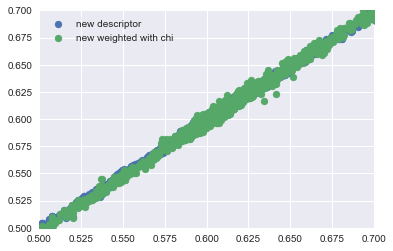

In [34]:
lower, upper = 0.5, 0.7
plt.figure()
plt.scatter(dataset.testing[1].flatten(), p_nn.flatten(),  label="new descriptor")
plt.scatter(dataset.testing[1].flatten(), p_nn_chi.flatten(), label="new weighted with chi")
plt.legend()


plt.xlim([lower, upper])
plt.ylim([lower, upper])

plt.show()


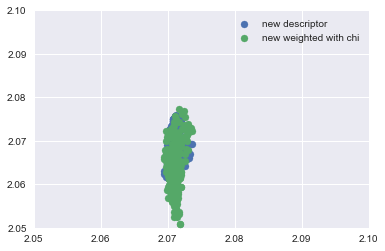

In [35]:
lower, upper = 2.05, 2.1
plt.figure()
plt.scatter(dataset.testing[1].flatten(), p_nn.flatten(), label="new descriptor")
plt.scatter(dataset.testing[1].flatten(), p_nn_chi.flatten(), label="new weighted with chi")
plt.legend()


plt.xlim([lower, upper])
plt.ylim([lower, upper])

plt.show()


# Spherical harmonics 
the angular descriptros will be spherical harmonics now

In [70]:
from scipy.special import sph_harm

l_max = 2

def atomic_descriptor_spherical_harmonics(R):
    """R... direction atom i to atom j"""
    r, phi, theta = spherical_coordinates(R)
    G = []
    
    for r_s in R_s:
        G.append(symmetry_function(r, r_s) * cut_off(r, R_cutoff))
       
    for l in range(l_max + 1):
        for m in range(-l, l + 1):
            Y = sph_harm(m, l, theta, phi)
            G.append(np.real(Y))
            G.append(np.imag(Y))
            
    return G

def calculate_descriptor_spherical_harmonics(molecule_geometry,  number_of_descriptors):
    
    descriptor_molecule = []
    
    for i, geom_i in enumerate(molecule_geometry):
        
        descriptor_atom = np.zeros(number_of_descriptors)
        
        for j, geom_j in enumerate(molecule_geometry):
            if i == j:
                continue
            
            descriptor_atom += CHI[geom_j[0]] *  \
                np.array(atomic_descriptor_spherical_harmonics(np.array(geom_i[1]) - np.array(geom_j[1])))
            
        descriptor_molecule.append(descriptor_atom)
    return descriptor_molecule

In [78]:
molecules = np.load("../data/400/molecules400.npy")
descriptors_spherical_harm = np.array([calculate_descriptor_spherical_harmonics(list(mol.geometry), n_r + 2*9) for mol in molecules])


In [81]:
descriptors_spherical_harm = descriptors_spherical_harm.reshape(603, -1)
descriptors_spherical_harm.shape

(603, 230)

In [76]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset, extract_triu

molecules = np.load("../data/400/molecules400.npy")

dataset_spherical_harm, molecules = make_butadien_dataset(
    molecules,
    descriptors_spherical_harm,
    np.array(list(map(lambda x: extract_triu(x, dim), P))),
    test_samples=100
)

[-] 2018-06-21 23:06:03: Data set normalized. Mean value std: 0.7571332678088127


In [83]:
from SCFInitialGuess.nn.training import Trainer
from SCFInitialGuess.nn.networks import EluTrNNN
from SCFInitialGuess.nn.cost_functions import RegularizedMSE

dim_in = (n_r + 2*9) * 10

#structure = [dim_in,  dim_triu * 2, dim_triu + 100, dim_triu]
structure = [dim_in,  dim_triu, dim_triu - 100, int(dim_triu/2), dim_triu]

trainer_spherical_harm = Trainer(
    EluTrNNN(structure),
    cost_function=RegularizedMSE(alpha=1e-7),
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3)
)

trainer_spherical_harm.setup()

network_spherical_harm, sess_spherical_harm = trainer_spherical_harm.train(
    dataset_spherical_harm,
    convergence_threshold=5e-7
)

[-] 2018-06-21 23:09:01: No target graph specified for Trainer setup. Creating new graph ...
[-] 2018-06-21 23:09:01: Setting up the training in the target graph ...
[-] 2018-06-21 23:09:01: network ...
[-] 2018-06-21 23:09:01: error function ...
[-] 2018-06-21 23:09:01: cost function ...
[-] 2018-06-21 23:09:02: training step
[-] 2018-06-21 23:09:02: Starting network training ...
[ ] 2018-06-21 23:09:02: Val. Cost: 9.476E-02. Error: 9.476E-02. Diff: 1.0E+10
[ ] 2018-06-21 23:09:03: Val. Cost: 2.512E-04. Error: 2.494E-04. Diff: 9.5E-02
[ ] 2018-06-21 23:09:03: Val. Cost: 2.462E-04. Error: 2.443E-04. Diff: 5.1E-06
[ ] 2018-06-21 23:09:04: Val. Cost: 1.903E-04. Error: 1.883E-04. Diff: 5.6E-05
[ ] 2018-06-21 23:09:05: Val. Cost: 1.228E-04. Error: 1.207E-04. Diff: 6.8E-05
[ ] 2018-06-21 23:09:06: Val. Cost: 8.896E-05. Error: 8.672E-05. Diff: 3.4E-05
[ ] 2018-06-21 23:09:07: Val. Cost: 7.666E-05. Error: 7.432E-05. Diff: 1.2E-05
[ ] 2018-06-21 23:09:07: Val. Cost: 7.800E-05. Error: 7.559E-05

In [90]:
with trainer.graph.as_default():
    p_nn_spherical_harm = network_spherical_harm.run(sess_spherical_harm, dataset_spherical_harm.testing[0])

In [92]:
from SCFInitialGuess.utilities.analysis import measure_absolute_error, statistics
print(statistics(measure_absolute_error(p_nn_spherical_harm, dataset_spherical_harm)))


(0.0011506416934754433, 0.0001737818270626527)


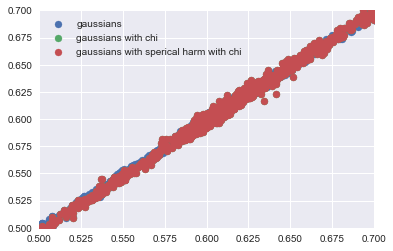

In [93]:
lower, upper = 0.5, 0.7
plt.figure()
plt.scatter(dataset.testing[1].flatten(), p_nn.flatten(),  label="gaussians")
plt.scatter(dataset.testing[1].flatten(), p_nn_chi.flatten(), label="gaussians with chi")
plt.scatter(dataset.testing[1].flatten(), p_nn_chi.flatten(), label="gaussians with sperical harm with chi")
plt.legend()


plt.xlim([lower, upper])
plt.ylim([lower, upper])

plt.show()